In [1]:
import sys
sys.path.insert(0, '../../../network')

In [2]:
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule
from sequences import GaussianSequence
import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi
ctx = Population(N=1000, tau=1e-2, phi=phi, name='ctx')
bg = Population(N=1000, tau=1e-2, phi=phi, name='bg')
plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8) 

S, P = 1, 3
sequences_ctx = [GaussianSequence(P,ctx.size, seed=11) for i in range(S)]
patterns_ctx = np.stack([s.inputs for s in sequences_ctx])
sequences_bg = [GaussianSequence(P,ctx.size, seed=367) for i in range(S)]
patterns_bg = np.stack([s.inputs for s in sequences_bg])

J_cc = SparseConnectivity(source=ctx, target=ctx, p=0.5)
synapse_cc = LinearSynapse(J_cc.K, A=2)
J_cc.store_attractors(patterns_ctx[0], patterns_ctx[0], synapse_cc.h_EE, 
                      plasticity.f, plasticity.g)
J_bb = SparseConnectivity(source=bg, target=bg, p=0.5)
synapse_bb = LinearSynapse(J_bb.K, A=5)
J_bb.store_attractors(patterns_bg[0], patterns_bg[0], synapse_bb.h_EE, 
                      plasticity.f, plasticity.g)
J_cb  = SparseConnectivity(source=bg, target=ctx, p=0.5)
synapse_cb = LinearSynapse(J_cb.K, A=3.5)
J_cb.store_attractors(patterns_bg[0], patterns_ctx[0], synapse_cb.h_EE, 
                      plasticity.f, plasticity.g)

J_bc = SparseConnectivity(source=ctx, target=bg, p=0.5)
synapse_bc = LinearSynapse(J_bc.K, A=3.5)
J_bc.store_sequences(patterns_ctx, patterns_bg, synapse_bc.h_EE, plasticity.f, plasticity.g)
net_ctx = RateNetwork(ctx, c_EE=J_cc, c_IE=J_bc, formulation=4)
net_bg = RateNetwork(bg, c_II=J_bb, c_EI=J_cb, formulation=4)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 7061.89it/s]
INFO:connectivity:Building connections from bg to bg
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6988.31it/s]
INFO:connectivity:Building connections from bg to ctx
INFO:connectivity:Storing attractors
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6914.82it/s]
INFO:connectivity:Building connections from ctx to bg
INFO:connectivity:Storing sequences
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]
INFO:connectivity:Applying synaptic transfer function
INFO:connectivity:Building sparse matrix


In [4]:
init_input_ctx = np.random.RandomState().normal(0,1,size=patterns_ctx[0][0].shape)
init_input_bg = np.random.RandomState().normal(0,1,size=patterns_bg[0][0].shape)
# init_input_ctx = patterns_ctx[0][0]
# init_input_bg = patterns_bg[0][0]
T=2
mouse = ReachingTask(3, alpha=0.5)
net_ctx.simulate_learning(mouse, net_bg, T, init_input_ctx, init_input_bg, 
                          phi(patterns_ctx[0]), phi(patterns_bg[0]), plasticity)

INFO:network:Integrating network dynamics
  3%|█                                        | 51/1999 [00:03<00:49, 39.62it/s]

null-->reach


  5%|█▉                                       | 93/1999 [00:03<00:32, 58.93it/s]

reach-->lick


 16%|██████▍                                 | 324/1999 [00:07<00:26, 63.02it/s]

lick-->lick


 28%|███████████▏                            | 562/1999 [00:11<00:22, 63.27it/s]

lick-->reach


 29%|███████████▋                            | 583/1999 [00:11<00:22, 63.27it/s]

reach-->lick


 41%|████████████████▎                       | 814/1999 [00:15<00:18, 63.34it/s]

lick-->lick


 52%|████████████████████▍                  | 1045/1999 [00:18<00:15, 63.25it/s]

lick-->lick


 65%|█████████████████████████▎             | 1297/1999 [00:22<00:11, 63.15it/s]

lick-->lick


 76%|█████████████████████████████▋         | 1521/1999 [00:26<00:07, 63.29it/s]

lick-->lick


 87%|██████████████████████████████████     | 1745/1999 [00:30<00:03, 63.54it/s]

lick-->lick


100%|██████████████████████████████████████▉| 1997/1999 [00:33<00:00, 63.32it/s]

lick-->lick


In [5]:
# overlaps_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi)
correlations_ctx = sequences_ctx[0].overlaps(net_ctx, ctx, phi=phi, correlation=True)
overlaps_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi)
correlations_bg = sequences_bg[0].overlaps(net_bg, bg, phi=phi, correlation=True)

INFO:sequences:Computing correlations

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.63s/it]
INFO:sequences:Computing overlaps

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 36.12it/s]
INFO:sequences:Computing correlations

100%|█████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


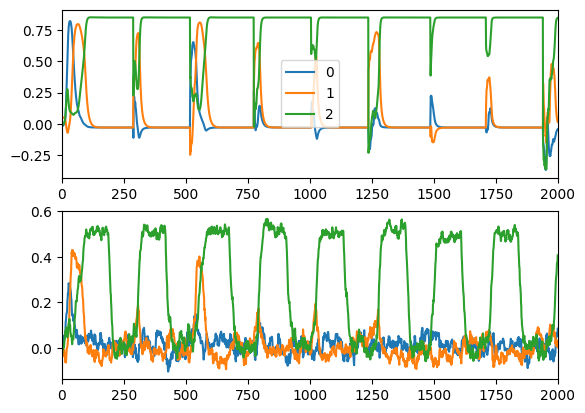

100%|███████████████████████████████████████| 1999/1999 [00:44<00:00, 63.32it/s]

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,1)
a, b =  0, 2000
for i, v in enumerate(correlations_ctx):
    axes[0].plot(v, label=str(i))
    axes[0].set_xlim(a, b)
for i, v in enumerate(correlations_bg):
    axes[1].plot(v, label=str(i))
    axes[1].set_xlim(a, b)
    axes[0].legend()